In [1]:
#import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from keras.datasets import mnist
from keras.datasets import cifar10
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import openml as oml
from keras.models import load_model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
import openml as oml
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

from keras.utils import np_utils

oml.config.apikey = 'b15b073c6fea6dc55b08f051f5e1abf9'
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size


c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [76]:


def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('SVHN/train_32x32.mat')
X_test, y_test = load_data('SVHN/test_32x32.mat')
X_extra, y_extra = load_data('SVHN/extra_32x32.mat')

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

TypeError: 'NoneType' object is not iterable

In [5]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]

print("Training", X_train.shape)
print("Test", X_test.shape)
print("Extra", X_extra.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0] + X_extra.shape[0]

print("Total Number of Images", num_images)

Training (73257, 32, 32, 3)
Test (26032, 32, 32, 3)
Extra (531131, 32, 32, 3)

Total Number of Images 630420


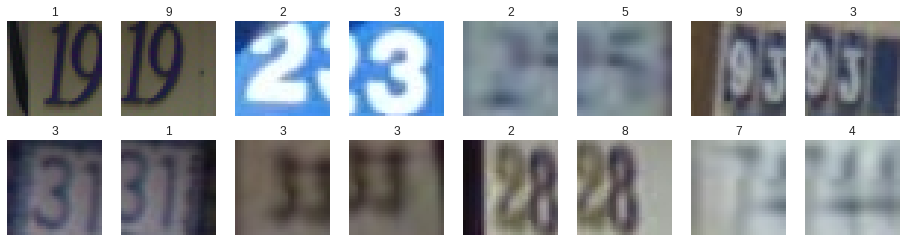

In [5]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])
        
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

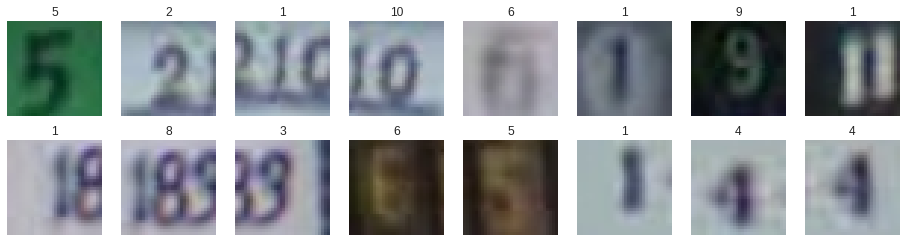

In [6]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

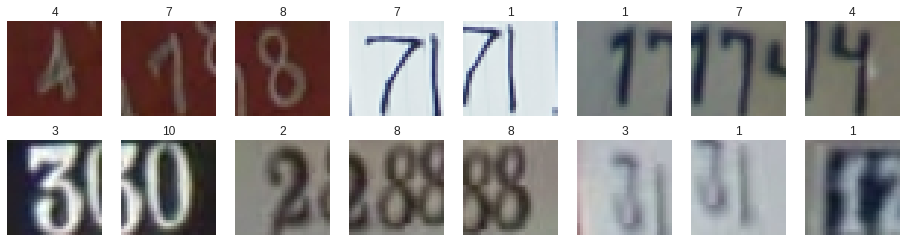

In [7]:
# Plot some extra set images
plot_images(X_extra, y_extra, 2, 8)

In [8]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


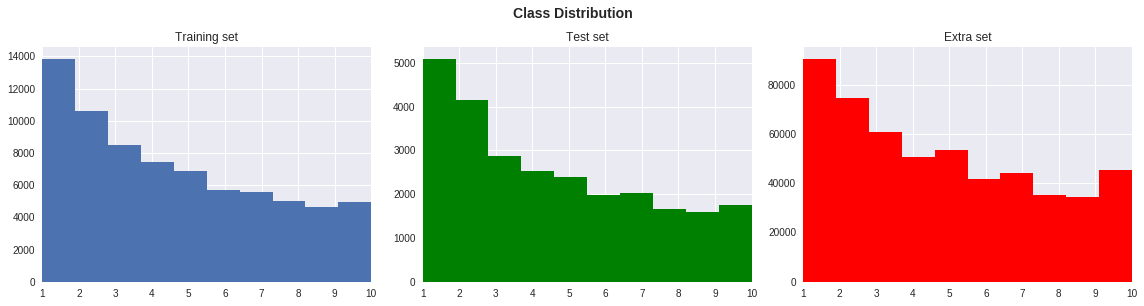

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

ax3.hist(y_extra, color='r', bins=10);
ax3.set_title("Extra set");

fig.tight_layout()

In [10]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_extra[y_extra == 10] = 0

In [8]:
def balanced_subsample(y, s):
    """Return a balanced subsample of the population"""
    sample = []
    # For every label in the dataset
    for label in np.unique(y):
        # Get the index of all images with a specific label
        images = np.where(y==label)[0]
        # Draw a random sample from the images
        random_sample = np.random.choice(images, size=s, replace=False)
        # Add the random sample to our subsample list
        sample += random_sample.tolist()
    return sample

In [8]:
# Pick 400 samples per class from the training samples
train_samples = balanced_subsample(y_train, 400)
# Pick 200 samples per class from the extra dataset
extra_samples = balanced_subsample(y_extra, 200)

X_val, y_val = np.copy(X_train[train_samples]), np.copy(y_train[train_samples])

# Remove the samples to avoid duplicates
X_train = np.delete(X_train, train_samples, axis=0)
y_train = np.delete(y_train, train_samples, axis=0)

X_val = np.concatenate([X_val, np.copy(X_extra[extra_samples])])
y_val = np.concatenate([y_val, np.copy(y_extra[extra_samples])])

# Remove the samples to avoid duplicates
X_extra = np.delete(X_extra, extra_samples, axis=0)
y_extra = np.delete(y_extra, extra_samples, axis=0)

X_train = np.concatenate([X_train, X_extra])
y_train = np.concatenate([y_train, y_extra])
X_test, y_test = X_test, y_test

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Validation', X_val.shape, y_val.shape)

Training (598388, 32, 32, 3) (598388,)
Test (26032, 32, 32, 3) (26032,)
Validation (6000, 32, 32, 3) (6000,)


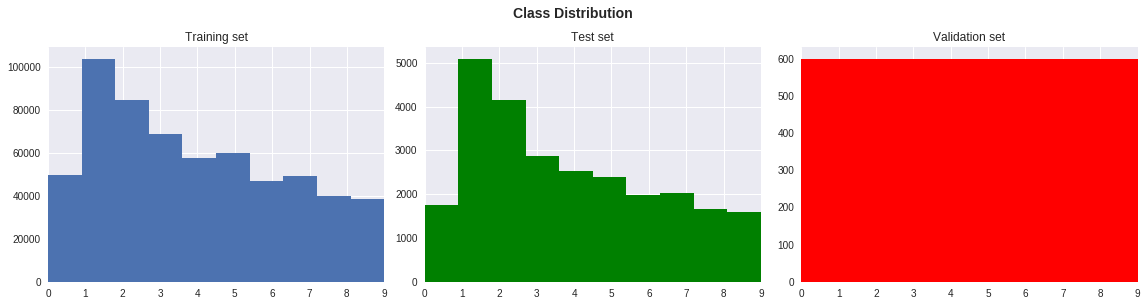

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(0, 9)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

ax3.hist(y_val, color='r', bins=10);
ax3.set_title("Validation set");

fig.tight_layout()

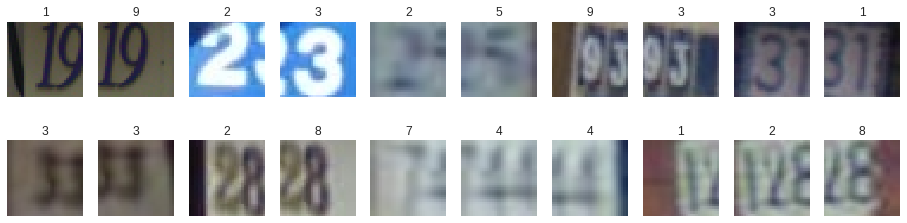

In [14]:
# Assert that we did not remove or add any duplicates
assert(num_images == X_train.shape[0] + X_test.shape[0] + X_val.shape[0])

# Display some samples images from the training set
plot_images(X_train, y_train, 2, 10)

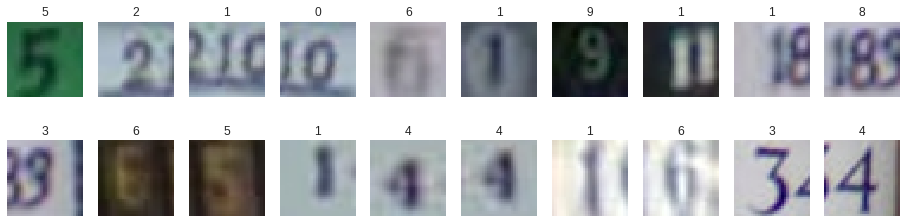

In [15]:
# Display some samples images from the test set
plot_images(X_test, y_test, 2, 10)

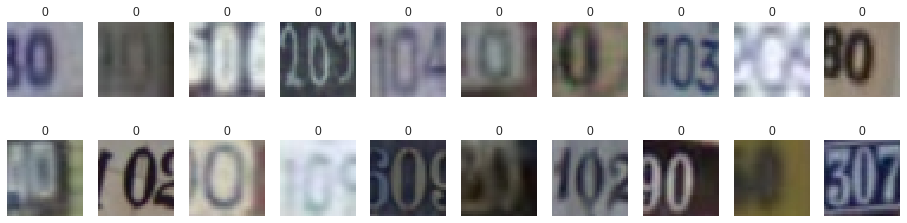

In [16]:
# Display some samples images from the validation set
plot_images(X_val, y_val, 2, 10)

In [9]:
suffixes = ['B', 'KB', 'MB', 'GB']

def humansize(nbytes):
    if nbytes == 0: return '0 B'
    i = 0
    while nbytes >= 1024:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

In [11]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
valid_greyscale = rgb2gray(X_val).astype(np.float32)

# Keep the size before convertion
size_before = (X_train.nbytes, X_test.nbytes, X_val.nbytes)

# Size after transformation
size_after = (train_greyscale.nbytes, test_greyscale.nbytes, valid_greyscale.nbytes)

print("Dimensions")
print("Training set", X_train.shape, train_greyscale.shape)
print("Test set", X_test.shape, test_greyscale.shape)
print("Validation set", X_val.shape, valid_greyscale.shape)
print('')

print("Data Type")
print("Training set", X_train.dtype, train_greyscale.dtype)
print("Test set", X_test.dtype, test_greyscale.dtype)
print("Validation set", X_val.dtype, valid_greyscale.dtype)
print('')

print("Dataset Size")
print("Training set", humansize(size_before[0]), humansize(size_after[0]))
print("Test set", humansize(size_before[1]), humansize(size_after[1]))
print("Validation set", humansize(size_before[2]), humansize(size_after[2]))

plot_images(X_train, y_train, 1, 10)
plot_images(train_greyscale, y_train, 1, 10)

MemoryError: 

In [12]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Test set", y_test.shape)
print("Training set", y_val.shape)

Training set (598388, 10)
Test set (26032, 10)
Training set (6000, 10)


In [2]:
import h5py

# Create file
h5f = h5py.File('SVHN/SVHN_single_cut.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

NameError: name 'X_train' is not defined

In [3]:
# Open the file as readonly
import h5py
h5f = h5py.File('SVHN/SVHN_single.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (598388, 32, 32, 3) (598388, 10)
Validation set (6000, 32, 32, 3) (6000, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [22]:
# We know that SVHN images have 32 pixels in each dimension
img_size = X_train.shape[1]

# Greyscale images only have 1 color channel
num_channels = X_train.shape[-1]

# Number of classes, one class for each of 10 digits
num_classes = y_train.shape[1]

In [7]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

# Subtract it equally from all splits
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_val = (train_mean - X_val) / train_std

MemoryError: 

In [6]:
# Pick 1000 samples per class from the training samples
train_samples = balanced_subsample_categorical(y_train, 6000)



[     0      8     16 ... 598379 598380 598386]
[     2      4     11 ... 598365 598381 598385]
[     3      7      9 ... 598362 598370 598375]
[    14     15     24 ... 598374 598382 598387]
[     5     26     33 ... 598353 598372 598384]
[    20     22     28 ... 598344 598378 598383]
[    13     31     44 ... 598330 598358 598369]
[    12     18     45 ... 598316 598334 598373]
[     1      6     32 ... 598340 598357 598371]
[    47     78     87 ... 598326 598347 598348]


In [59]:
# Remove the samples to avoid duplicates
X_dum = np.take(X_train,train_samples,axis=0)
y_dum = np.take(y_train,train_samples,axis=0)


print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Validation', X_val.shape, y_val.shape)
print('Dum', X_dum.shape, y_dum.shape)


Training (598388, 32, 32, 3) (598388, 10)
Test (26032, 32, 32, 3) (26032, 10)
Validation (6000, 32, 32, 3) (6000, 10)
Dum (60000, 32, 32, 3) (60000, 10)


In [25]:
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
def balanced_subsample_categorical(y, s):
    """Return a balanced subsample of the population"""
    sample = []
    # For every label in the dataset
    for ii in range(10):
        # Get the index of all images with a specific label
        images = np.ndarray.flatten(np.where((y[:,ii] == 1))[0])
        print(images)
        # Draw a random sample from the images
        random_sample = np.random.choice(images, size=s, replace=False)
        # Add the random sample to our subsample list
        sample += random_sample.tolist()
    return sample

In [11]:
tes=balanced_subsample_categorical(y_train,100)


[     0      8     16 ... 598379 598380 598386]
[     2      4     11 ... 598365 598381 598385]
[     3      7      9 ... 598362 598370 598375]
[    14     15     24 ... 598374 598382 598387]
[     5     26     33 ... 598353 598372 598384]
[    20     22     28 ... 598344 598378 598383]
[    13     31     44 ... 598330 598358 598369]
[    12     18     45 ... 598316 598334 598373]
[     1      6     32 ... 598340 598357 598371]
[    47     78     87 ... 598326 598347 598348]


In [60]:

 
model = Sequential()
 
model.add(Conv2D(6, (3, 3), activation="tanh", input_shape=(32, 32, 3)))
# model.output_shape should be (None, 26, 26, 6)
print(model.output_shape)
# model.add(Activation("tanh"))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.output_shape should be (None, 13, 13, 6)
print(model.output_shape)
 
model.add(Conv2D(16, (2, 2), activation="tanh"))
# model.output_shape should be (None, 12, 12, 16)
print(model.output_shape)
# model.add(Activation("tanh"))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.output_shape should be (None, 6, 6, 16)
print(model.output_shape)
 
model.add(Flatten())
# model.output_shape should be (None, 576)
print(model.output_shape)
 
model.add(Dense(256, activation="tanh"))
# model.output_shape should be (None, 256)
 
 
model.add(Dense(10, activation="softmax"))
# model.output_shape should be (None, 10)
print(model.output_shape)
 
model.compile("adadelta", "categorical_crossentropy", metrics=['accuracy'])
 
model.fit(X_dum, y_dum, batch_size=128, epochs=30, validation_data=(X_val, y_val))
 
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
model.save("lenet_svhn_30epoch.h5")

(None, 30, 30, 6)
(None, 15, 15, 6)
(None, 14, 14, 16)
(None, 7, 7, 16)
(None, 784)
(None, 10)
Train on 60000 samples, validate on 6000 samples
Epoch 1/30
60000/60000 [==============================] - 21s 357us/step - loss: 1.8054 - acc: 0.3834 - val_loss: 1.4297 - val_acc: 0.5352
Epoch 2/30
60000/60000 [==============================] - 20s 337us/step - loss: 0.9716 - acc: 0.6976 - val_loss: 0.9995 - val_acc: 0.6828
Epoch 3/30
60000/60000 [==============================] - 21s 349us/step - loss: 0.7097 - acc: 0.7783 - val_loss: 0.8062 - val_acc: 0.7445
Epoch 4/30
60000/60000 [==============================] - 20s 334us/step - loss: 0.5798 - acc: 0.8187 - val_loss: 0.7515 - val_acc: 0.7647
Epoch 5/30
60000/60000 [==============================] - 20s 334us/step - loss: 0.5028 - acc: 0.8440 - val_loss: 0.7178 - val_acc: 0.7753
Epoch 6/30
60000/60000 [==============================] - 20s 337us/step - loss: 0.4487 - acc: 0.8604 - val_loss: 0.6458 - val_acc: 0.7957
Epoch 7/30
60000/60000

In [61]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
valid_greyscale = rgb2gray(X_val).astype(np.float32)

# Keep the size before convertion
size_before = (X_train.nbytes, X_test.nbytes, X_val.nbytes)

# Size after transformation
size_after = (train_greyscale.nbytes, test_greyscale.nbytes, valid_greyscale.nbytes)

print("Dimensions")
print("Training set", X_train.shape, train_greyscale.shape)
print("Test set", X_test.shape, test_greyscale.shape)
print("Validation set", X_val.shape, valid_greyscale.shape)
print('')

print("Data Type")
print("Training set", X_train.dtype, train_greyscale.dtype)
print("Test set", X_test.dtype, test_greyscale.dtype)
print("Validation set", X_val.dtype, valid_greyscale.dtype)
print('')

print("Dataset Size")
print("Training set", humansize(size_before[0]), humansize(size_after[0]))
print("Test set", humansize(size_before[1]), humansize(size_after[1]))
print("Validation set", humansize(size_before[2]), humansize(size_after[2]))

plot_images(X_train, y_train, 1, 10)
plot_images(train_greyscale, y_train, 1, 10)

In [63]:
import h5py

# Create file
h5f = h5py.File('SVHN/SVHN_single_cut.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

Dimensions
Training set (60000, 32, 32, 3) (60000, 32, 32, 1)
Test set (26032, 32, 32, 3) (26032, 32, 32, 1)
Validation set (6000, 32, 32, 3) (6000, 32, 32, 1)

Data Type
Training set uint8 float32
Test set uint8 float32
Validation set uint8 float32

Dataset Size
Training set 175.78 MB 234.38 MB
Test set 76.27 MB 101.69 MB
Validation set 17.58 MB 23.44 MB


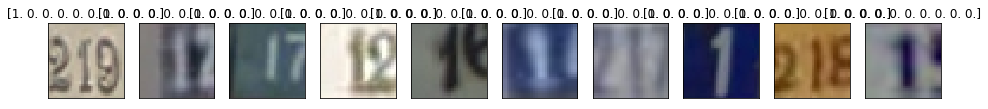

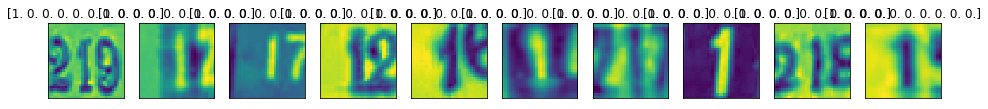

In [77]:
suffixes = ['B', 'KB', 'MB', 'GB']

def humansize(nbytes):
    if nbytes == 0: return '0 B'
    i = 0
    while nbytes >= 1024:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
valid_greyscale = rgb2gray(X_val).astype(np.float32)

# Keep the size before convertion
size_before = (X_train.nbytes, X_test.nbytes, X_val.nbytes)

# Size after transformation
size_after = (train_greyscale.nbytes, test_greyscale.nbytes, valid_greyscale.nbytes)

print("Dimensions")
print("Training set", X_train.shape, train_greyscale.shape)
print("Test set", X_test.shape, test_greyscale.shape)
print("Validation set", X_val.shape, valid_greyscale.shape)
print('')

print("Data Type")
print("Training set", X_train.dtype, train_greyscale.dtype)
print("Test set", X_test.dtype, test_greyscale.dtype)
print("Validation set", X_val.dtype, valid_greyscale.dtype)
print('')

print("Dataset Size")
print("Training set", humansize(size_before[0]), humansize(size_after[0]))
print("Test set", humansize(size_before[1]), humansize(size_after[1]))
print("Validation set", humansize(size_before[2]), humansize(size_after[2]))

def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

plot_images(X_train, y_train, 1, 10)
plot_images(train_greyscale, y_train, 1, 10)


In [7]:
import h5py
# Open the file as readonly
h5f = h5py.File('SVHN/SVHN_single.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (598388, 32, 32, 3) (598388, 10)
Validation set (6000, 32, 32, 3) (6000, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [7]:
X_dum = np.take(X_train,train_samples,axis=0)
y_dum = np.take(y_train,train_samples,axis=0)
print(X_dum.shape)
print(y_dum.shape)
X_train=X_dum
y_train=y_dum

(60000, 32, 32, 3)
(60000, 10)


In [17]:
#resnet

#resnet https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = X_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
#if subtract_pixel_mean:
#    x_train_mean = np.mean(x_train, axis=0)
#    x_train -= x_train_mean
#    x_test -= x_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_block(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    x = inputs
    if conv_first:
        x = Conv2D(num_filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation:
            x = Activation(activation)(x)
        return x
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    The number of filters doubles when the feature maps size
    is halved.
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters = 16
    num_sub_blocks = int((depth - 2) / 6)

    x = resnet_block(inputs=inputs)
    # Instantiate convolutional base (stack of blocks).
    for i in range(3):
        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_block(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if is_first_layer_but_not_first_block:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = 2 * num_filters

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    Features maps sizes: 16(input), 64(1st sub_block), 128(2nd), 256(3rd)
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters_in = 16
    num_filters_out = 64
    filter_multiplier = 4
    num_sub_blocks = int((depth - 2) / 9)

    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_block(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate convolutional base (stack of blocks).
    activation = None
    batch_normalization = False
    for i in range(3):
        if i > 0:
            filter_multiplier = 2
        num_filters_out = num_filters_in * filter_multiplier

        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            activation = 'relu'
            batch_normalization = True
            y = resnet_block(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if j == 0:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(Xtest, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                        validation_data=(X_test, y_test),
                        epochs=10, verbose=1, workers=-1,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
model.save("resnet20v1_svhn_10epoch.h5")

x_train shape: (60000, 32, 32, 3)
60000 train samples
26032 test samples
y_train shape: (60000, 10)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_3

Learning rate:  0.001
Epoch 1/10
469/469 [==============================] - 954s 2s/step - loss: 1.0685 - acc: 0.6782 - val_loss: 1.0981 - val_acc: 0.6894
Learning rate:  0.001
Epoch 2/10
469/469 [==============================] - 934s 2s/step - loss: 0.4085 - acc: 0.9120 - val_loss: 0.6629 - val_acc: 0.8314
Learning rate:  0.001
Epoch 3/10
469/469 [==============================] - 933s 2s/step - loss: 0.3397 - acc: 0.9316 - val_loss: 0.5388 - val_acc: 0.8682
Learning rate:  0.001
Epoch 4/10
469/469 [==============================] - 934s 2s/step - loss: 0.3086 - acc: 0.9410 - val_loss: 0.6344 - val_acc: 0.8424
Learning rate:  0.001
Epoch 5/10
469/469 [==============================] - 934s 2s/step - loss: 0.2857 - acc: 0.9467 - val_loss: 0.4756 - val_acc: 0.8894
Learning rate:  0.001
Epoch 6/10
469/469 [==============================] - 934s 2s/step - loss: 0.2702 - acc: 0.9519 - val_loss: 0.4958 - val_acc: 0.8832
Learning rate:  0.001
Epoch 7/10
469/469 [============================

In [20]:

#vgg-like

model3=Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
          input_shape=X_train.shape[1:], activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), padding="valid", activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(256))
model3.add(LeakyReLU())
model3.add(Dropout(0.5))
model3.add(Dense(256))
model3.add(LeakyReLU())
#model2.add(Dropout(0.5))
model3.add(Dense(10, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model3.summary()

model3.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
 
score = model3.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
model3.save("vgglike_svhn_10epoch.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 256)         0         
__________

In [16]:
#resnet

#resnet https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = X_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
#if subtract_pixel_mean:
#    x_train_mean = np.mean(x_train, axis=0)
#    x_train -= x_train_mean
#    x_test -= x_train_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_block(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    x = inputs
    if conv_first:
        x = Conv2D(num_filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation:
            x = Activation(activation)(x)
        return x
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    The number of filters doubles when the feature maps size
    is halved.
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters = 16
    num_sub_blocks = int((depth - 2) / 6)

    x = resnet_block(inputs=inputs)
    # Instantiate convolutional base (stack of blocks).
    for i in range(3):
        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_block(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if is_first_layer_but_not_first_block:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = 2 * num_filters

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    Features maps sizes: 16(input), 64(1st sub_block), 128(2nd), 256(3rd)
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters_in = 16
    num_filters_out = 64
    filter_multiplier = 4
    num_sub_blocks = int((depth - 2) / 9)

    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_block(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate convolutional base (stack of blocks).
    activation = None
    batch_normalization = False
    for i in range(3):
        if i > 0:
            filter_multiplier = 2
        num_filters_out = num_filters_in * filter_multiplier

        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            activation = 'relu'
            batch_normalization = True
            y = resnet_block(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if j == 0:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(Xtest, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                        validation_data=(X_test, y_test),
                        epochs=10, verbose=1, workers=-1,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
model.save("resnet20v2_svhn_10epoch.h5")

x_train shape: (60000, 32, 32, 3)
60000 train samples
26032 test samples
y_train shape: (60000, 10)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1

Learning rate:  0.001
Epoch 1/10
469/469 [==============================] - 1572s 3s/step - loss: 1.4850 - acc: 0.5955 - val_loss: 0.9452 - val_acc: 0.7933
Learning rate:  0.001
Epoch 2/10
469/469 [==============================] - 1570s 3s/step - loss: 0.5782 - acc: 0.9081 - val_loss: 1.0067 - val_acc: 0.7718
Learning rate:  0.001
Epoch 3/10
469/469 [==============================] - 1560s 3s/step - loss: 0.4811 - acc: 0.9299 - val_loss: 0.8963 - val_acc: 0.7981
Learning rate:  0.001
Epoch 4/10
469/469 [==============================] - 1562s 3s/step - loss: 0.4301 - acc: 0.9385 - val_loss: 0.7132 - val_acc: 0.8529
Learning rate:  0.001
Epoch 5/10
469/469 [==============================] - 1571s 3s/step - loss: 0.3968 - acc: 0.9429 - val_loss: 0.7985 - val_acc: 0.8227
Learning rate:  0.001
Epoch 6/10
469/469 [==============================] - 1561s 3s/step - loss: 0.3694 - acc: 0.9453 - val_loss: 0.6084 - val_acc: 0.8634
Learning rate:  0.001
Epoch 7/10
469/469 [======================

In [18]:
from keras.layers import Input, merge
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Dense, Dropout, Flatten
input_layer = Input(shape=(32, 32,3), name="input")

#conv 1
conv1 = Convolution2D(96, 3, 3, activation='relu', init='glorot_uniform',subsample=(2,2),border_mode='valid')(input_layer)

#maxpool 1
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv1)

#fire 1
fire2_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool1)
fire2_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire2_squeeze)
fire2_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire2_squeeze)
merge1 = merge(inputs=[fire2_expand1, fire2_expand2], mode="concat", concat_axis=1)
fire2 = Activation("linear")(merge1)

#fire 2
fire3_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire2)
fire3_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire3_squeeze)
fire3_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire3_squeeze)
merge2 = merge(inputs=[fire3_expand1, fire3_expand2], mode="concat", concat_axis=1)
fire3 = Activation("linear")(merge2)

#fire 3
fire4_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire3)
fire4_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire4_squeeze)
fire4_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire4_squeeze)
merge3 = merge(inputs=[fire4_expand1, fire4_expand2], mode="concat", concat_axis=1)
fire4 = Activation("linear")(merge3)

#maxpool 4
maxpool4 = MaxPooling2D((2,2))(fire4)

#fire 5
fire5_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool4)
fire5_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire5_squeeze)
fire5_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire5_squeeze)
merge5 = merge(inputs=[fire5_expand1, fire5_expand2], mode="concat", concat_axis=1)
fire5 = Activation("linear")(merge5)

#fire 6
fire6_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire5)
fire6_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire6_squeeze)
fire6_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire6_squeeze)
merge6 = merge(inputs=[fire6_expand1, fire6_expand2], mode="concat", concat_axis=1)
fire6 = Activation("linear")(merge6)

#fire 7
fire7_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire6)
fire7_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire7_squeeze)
fire7_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire7_squeeze)
merge7 = merge(inputs=[fire7_expand1, fire7_expand2], mode="concat", concat_axis=1)
fire7 =Activation("linear")(merge7)

#fire 8
fire8_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire7)
fire8_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire8_squeeze)
fire8_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire8_squeeze)
merge8 = merge(inputs=[fire8_expand1, fire8_expand2], mode="concat", concat_axis=1)
fire8 = Activation("linear")(merge8)

#maxpool 8
maxpool8 = MaxPooling2D((2,2))(fire8)

#fire 9
fire9_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool8)
fire9_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire9_squeeze)
fire9_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire9_squeeze)
merge8 = merge(inputs=[fire9_expand1, fire9_expand2], mode="concat", concat_axis=1)
fire9 = Activation("linear")(merge8)
fire9_dropout = Dropout(0.5)(fire9)

#conv 10
conv10 = Convolution2D(10, 1, 1, init='glorot_uniform',border_mode='valid')(fire9_dropout)

#avgpool 1
avgpool10 = AveragePooling2D((13,13), strides=(1,1), border_mode='same')(conv10)

flatten = Flatten()(avgpool10)

softmax = Dense(10, activation="softmax")(flatten)

model = Model(input=input_layer, output=softmax)

model.summary()

model.compile(optimizer='adadelta', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_test, y_test))
 
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
model.save("squeezenet_svhn_3epoch.h5")

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), activation="relu", strides=(2, 2), padding="valid", kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), padding="valid", kernel_initializer="glorot_uniform")`
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((13, 13), strides=(1, 1), padding="same")`
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 15, 15, 96)   2688        input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 7, 7, 96)     0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 7, 7, 16)     1552        max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_51 

Train on 60000 samples, validate on 26032 samples
Epoch 1/3
60000/60000 [==============================] - 1755s 29ms/step - loss: 2.1631 - acc: 0.1805 - val_loss: 1.6782 - val_acc: 0.4407
Epoch 2/3
60000/60000 [==============================] - 1745s 29ms/step - loss: 0.9093 - acc: 0.7091 - val_loss: 0.7511 - val_acc: 0.7817
Epoch 3/3
26032/26032 [==============================] - 217s 8ms/step
Test score: 0.7574306811631348
Test accuracy: 0.77470036877689


In [11]:
from keras.layers import Input, merge
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
input_layer = Input(shape=(32, 32,3), name="input")


#conv 1
conv1 = Convolution2D(96, 3, 3, activation='relu', init='glorot_uniform',subsample=(2,2),border_mode='valid')(input_layer)

#maxpool 1
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv1)

#fire 1
fire2_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool1)
fire2_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire2_squeeze)
fire2_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire2_squeeze)
merge1 = merge(inputs=[fire2_expand1, fire2_expand2], mode="concat", concat_axis=1)
fire2 = Activation("linear")(merge1)

#fire 2
fire3_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire2)
fire3_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire3_squeeze)
fire3_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire3_squeeze)
merge2 = merge(inputs=[fire3_expand1, fire3_expand2], mode="concat", concat_axis=1)
fire3 = Activation("linear")(merge2)

#fire 3
fire4_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire3)
fire4_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire4_squeeze)
fire4_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire4_squeeze)
merge3 = merge(inputs=[fire4_expand1, fire4_expand2], mode="concat", concat_axis=1)
fire4 = Activation("linear")(merge3)

#maxpool 4
maxpool4 = MaxPooling2D((2,2))(fire4)

#fire 5
fire5_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool4)
fire5_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire5_squeeze)
fire5_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire5_squeeze)
merge5 = merge(inputs=[fire5_expand1, fire5_expand2], mode="concat", concat_axis=1)
fire5 = Activation("linear")(merge5)

#fire 6
fire6_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire5)
fire6_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire6_squeeze)
fire6_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire6_squeeze)
merge6 = merge(inputs=[fire6_expand1, fire6_expand2], mode="concat", concat_axis=1)
fire6 = Activation("linear")(merge6)

#fire 7
fire7_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire6)
fire7_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire7_squeeze)
fire7_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire7_squeeze)
merge7 = merge(inputs=[fire7_expand1, fire7_expand2], mode="concat", concat_axis=1)
fire7 =Activation("linear")(merge7)

#fire 8
fire8_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire7)
fire8_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire8_squeeze)
fire8_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire8_squeeze)
merge8 = merge(inputs=[fire8_expand1, fire8_expand2], mode="concat", concat_axis=1)
fire8 = Activation("linear")(merge8)

#maxpool 8
maxpool8 = MaxPooling2D((2,2))(fire8)

#fire 9
fire9_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(maxpool8)
fire9_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same')(fire9_squeeze)
fire9_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same')(fire9_squeeze)
merge8 = merge(inputs=[fire9_expand1, fire9_expand2], mode="concat", concat_axis=1)
fire9 = Activation("linear")(merge8)
fire9_dropout = Dropout(0.5)(fire9)

#conv 10
conv10 = Convolution2D(10, 1, 1, init='glorot_uniform',border_mode='valid')(fire9_dropout)

#avgpool 1
avgpool10 = AveragePooling2D((13,13), strides=(1,1), border_mode='same')(conv10)

flatten = Flatten()(avgpool10)

softmax = Dense(10, activation="softmax")(flatten)

model = Model(input=input_layer, output=softmax)

model.summary()

model.compile(optimizer='adadelta', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
 
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
model.save("squeezenet_svhn_10epoch.h5")

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), activation="relu", strides=(2, 2), padding="valid", kernel_initializer="glorot_uniform")`
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", padding="same", kernel_initializer="glorot_uniform")`
c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="g

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 15, 15, 96)   2688        input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 7, 7, 96)     0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 7, 7, 16)     1552        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
conv2d_55 

Train on 60000 samples, validate on 26032 samples
Epoch 1/10
60000/60000 [==============================] - 1736s 29ms/step - loss: 2.2483 - acc: 0.1367 - val_loss: 1.9502 - val_acc: 0.3029
Epoch 2/10
60000/60000 [==============================] - 1725s 29ms/step - loss: 1.3164 - acc: 0.5553 - val_loss: 0.8466 - val_acc: 0.7458
Epoch 3/10
60000/60000 [==============================] - 1725s 29ms/step - loss: 0.5371 - acc: 0.8350 - val_loss: 0.6331 - val_acc: 0.8101
Epoch 4/10
60000/60000 [==============================] - 1725s 29ms/step - loss: 0.3834 - acc: 0.8852 - val_loss: 0.5512 - val_acc: 0.8363
Epoch 5/10
60000/60000 [==============================] - 1725s 29ms/step - loss: 0.3149 - acc: 0.9059 - val_loss: 0.5236 - val_acc: 0.8529
Epoch 6/10
60000/60000 [==============================] - 1725s 29ms/step - loss: 0.2725 - acc: 0.9186 - val_loss: 0.4424 - val_acc: 0.8728
Epoch 7/10
60000/60000 [==============================] - 1726s 29ms/step - loss: 0.2423 - acc: 0.9274 - val_l

In [12]:

#vgg-like

model3=Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
          input_shape=X_train.shape[1:], activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), padding="valid", activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(256))
model3.add(LeakyReLU())
model3.add(Dropout(0.5))
model3.add(Dense(256))
model3.add(LeakyReLU())
#model2.add(Dropout(0.5))
model3.add(Dense(10, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model3.summary()

model3.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
 
score = model3.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
model3.save("vgglike_svhn_10epochv2.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 256)         0         
__________

KeyboardInterrupt: 